In [60]:
import numpy as np

In [61]:
class Loss:
    def __init__(self, lossType = "MSE"):
        self.lossType = lossType 
    
    def backwardPass(self, X, Y):
        if(self.lossType == "MSE"):
            return self.backwardPassMSE(X, Y)
        elif(self.lossType == "CE"):
            return self.backwardPassCE(X,Y)
        return
    
    def forwardPass(self, X, Y):
        if(self.lossType == "MSE"):
            return self.forwardPassMSE(X, Y)
        elif(self.lossType == "CE"):
            return self.forwardPassCE(X,Y)
        return
   
    def forwardPassMSE(self, X, Y):
        return ((X-Y).T)@(X-Y)*0.5
    
    def forwardPassCE(self, X, Y):
        return -np.sum(Y*np.log(X))
   
    def backwardPassMSE(self, P, Y):
        return P-Y
    
    def backwardPassCE(self,P,Y):
        return Y/P
    


In [62]:
class Activation:
    def __init__(self, act = "linear"):
        self.act = act 
    
    def backwardPass(self, X, dl_dn):
        if(self.act == "linear"):
            return self.backwardPassLinear(X, dl_dn)
        elif(self.act == "sigmoid"):
            return self.backwardPassSigmoid(X, dl_dn)
        elif(self.act == "softmax"):
            return self.backwardPassSoftmax(X, dl_dn)
        return
    
    def forwardPass(self, X):
        if(self.act == "linear"):
            return self.forwardPassLinear(X)
        elif(self.act == "sigmoid"):
            # print("OKKKK")
            return self.forwardPassSigmoid(X)
        elif(self.act == "softmax"):
            return self.forwardPassSoftmax(X)
        return
   
    def forwardPassLinear(self, X):
        return X
    
    def forwardPassSigmoid(self, X):
        # print("Getting Printed")
        # print(X)
        # print(1/(1 + np.exp(-X)))
        return (1/(1 + np.exp(-X)))
    
    def forwardPassSoftmax(self, X):
        retsum = np.sum(np.exp(X-np.max(X)), axis=1)
        retsum = retsum.reshape(X.shape[0],1)
        N = np.exp(X-np.max(X))/retsum

    def backwardPassLinear(self, X, dl_dn):
        return dl_dn
    
    def backwardPassSigmoid(self, X, dl_dn):
        temp = self.forwardPassSigmoid(X)
        return dl_dn*( temp * (1 - temp))

    def backwardPassSoftmax(self, X, dl_dn):
        N = self.forwardPassSoftmax(X)
        dl_dx = N*(dl_dn - np.sum(dl_dn*N, axis=1).reshape(X.shape[0], 1))
        return dl_dx
    



In [63]:
class Layer:
    def __init__(self, numNeurons = 1, numNeuronsPrev = 1, act = "linear", alpha = 1e-7):
        # Neurons in the current layer
        self.numNeurons = numNeurons
        # Neurons in the previous layer
        self.numNeuronsPrev = numNeuronsPrev
        # Weights for linear sum
        self.W = np.random.rand(numNeurons, numNeuronsPrev)
        # Bias of size Nx1
        self.B = np.random.rand(numNeurons, 1)
        # Activation function 
        self.activation = Activation(act)
        self.alpha = alpha
        self.input = None
        self.output = None

    def update(self, dl_dw, dl_db):
        self.W -= self.alpha*(dl_dw)
        self.B -= self.alpha*(dl_db)
    def forwardPasslinear(self, X, train=False):
        if(train):
            self.input = X
        return (self.W)@X + (self.B)
    
    def forwardPass(self, X):
        arg = self.forwardPasslinear(X, True)
        # print("Forward Pass : ", arg)
        return self.activation.forwardPass(arg)
    
    def backwardPasslinear(self, dl_ds):
        # dl_dx = np.zeros((dl_dw.shape[1], 1))
        dl_dx = self.W.T@dl_ds
        dl_dw = (dl_ds@((self.input).T))
        return (dl_dx, dl_dw)
    
    def backwardPass(self, dl_dh):
        # dl_ds where S = W@X + B
        dl_ds = self.activation.backwardPass(self.forwardPasslinear(self.input, True), dl_dh)  
        dl_dx, dl_dw = self.backwardPasslinear(dl_ds)

        self.update(dl_dw, dl_ds)
        return dl_dx

        # fw= self.forwardPasslinear(self.input)
        # dl_dx = dl_dh * (self.activation.backwardPass(fw))
        # return self.backwardPasslinear(dl_dx)

In [64]:
class NeuralNetwork:
    def __init__(self, listLayers = [], str = "MSE", inp = np.zeros((10,5)), pred = np.ones((10,1)), epochs = 1000):
        self.listLayers = listLayers
        self.lossObj = Loss(str)
        self.target = pred
        # Input data to the neural network
        self.input = inp
        self.epochs = epochs
    
    def forwardPassNN(self, i, Y):
        R = self.listLayers[i].forwardPass(Y)
        return R

    def train(self):
        for epoch in range(int(self.epochs)):
            loss = 0
            for d in range(len(self.input)):
                l = []
                Y = self.input[d].reshape(self.input.shape[1], 1)
                l.append(Y)
                for i in range(len(self.listLayers)):
                    Y = self.forwardPassNN(i, Y)
                    l.append(Y)
                
                targ = self.target[d].reshape(self.target.shape[1],1)
                myLoss = self.lossObj.forwardPass(Y, self.target[d])
                loss += myLoss
                dl_dh = self.lossObj.backwardPass(l[-1], self.target[d])
                for i in range(len(self.listLayers) -1, -1, -1):
                    dl_dh = self.listLayers[i].backwardPass(dl_dh)
            # print(loss/len(self.input))
    
    def test(self, dataPts, targets):
        ret = np.zeros((dataPts.shape[0], 1))
        for ind in range(len(dataPts)):
            Y = dataPts[ind].reshape(dataPts.shape[1], 1)
            # print(Y)
            for i in range(len(self.listLayers)):
                # print("Inside for loop: ", Y)
                Y = self.forwardPassNN(i, Y)
            ret[ind] = Y.item()
            # print("Outside For Loop : ", Y)
        return ret   


In [65]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
Y = raw_df.values[1::2, 2]
Y = Y.reshape((Y.shape[0],1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.01, random_state=42)

In [66]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(500, 13)
(6, 13)
(500, 1)
(6, 1)


In [67]:
layers = []

layers.append(Layer(13, X_train.shape[1], "sigmoid"))
layers.append(Layer(13, 13, "sigmoid"))
layers.append(Layer(1, 13, "linear"))
model = NeuralNetwork(layers, "MSE", X_train, Y_train)
model.train()


0.511508753243505


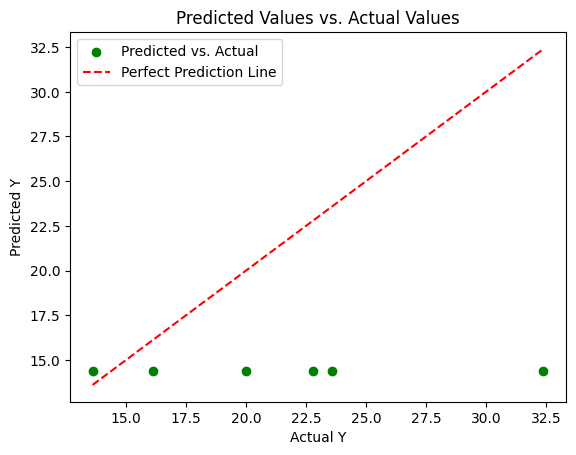

In [68]:
Y_pred = model.test(X_test, Y_test)

print(((np.sum((Y_pred-Y_test)**2)))*0.5*(1/506))
# Plotting the curve for predicted values versus actual values
# plt.scatter(Y_test, Y_pred, color='blue', label='Predicted vs. Actual')
# plt.plot([min(Y), max(Y)], [min(Y), max(Y)], linestyle='--', color='red', label='Perfect Prediction Line')
# plt.title('Predicted Values vs. Actual Values')
# plt.xlabel('Actual Y')
# plt.ylabel('Predicted Y')
# plt.legend()
# plt.show()

plt.scatter(Y_test, Y_pred, color='green', label='Predicted vs. Actual')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], linestyle='--', color='red', label='Perfect Prediction Line')
plt.title('Predicted Values vs. Actual Values')
plt.xlabel('Actual Y')
plt.ylabel('Predicted Y')
plt.legend()

# plt.ylim(min(Y_pred) - 0.001, max(Y_pred) + 0.001)

plt.show()


In [69]:
print(Y_pred)

print(layers[0].W)
# print(layers[1].W)
# print(layers[2].W)

[[14.35788343]
 [14.35788343]
 [14.35788343]
 [14.35788343]
 [14.35788343]
 [14.35788343]]
[[0.72630421 0.0268064  0.41877902 0.01538458 0.25122048 0.9568949
  0.46109642 0.18492257 0.0212529  0.8951602  0.18517178 0.40041565
  0.30925834]
 [0.66789214 0.97326917 0.86149712 0.83337427 0.45359387 0.84758985
  0.11903453 0.55240396 0.45432991 0.40725238 0.3094903  0.16526527
  0.19090179]
 [0.3381144  0.81172826 0.05378293 0.28832787 0.09956973 0.81754136
  0.13088866 0.99364718 0.69061086 0.74574532 0.46712593 0.96371113
  0.11507892]
 [0.38940402 0.33332591 0.83814638 0.00976355 0.49621981 0.41214055
  0.60790964 0.33356099 0.2868415  0.60096616 0.37309432 0.90423547
  0.60307257]
 [0.07579525 0.31228083 0.29817292 0.83813175 0.72676035 0.65177383
  0.79827918 0.08946443 0.72961474 0.22279147 0.26249834 0.46615773
  0.09861176]
 [0.28599587 0.84839338 0.98130753 0.51342761 0.25067819 0.49604683
  0.70430102 0.73107543 0.39945948 0.4193339  0.60163398 0.17949337
  0.13012977]
 [0.031411